In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from scipy import integrate, interpolate
from lmfit import minimize, Parameters
import emcee
import corner
import pandas as pd

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Specify atomic parameters for LyA

In [3]:
wav0_rest = 1215.6701
f = 0.416400
gamma_nu = 6.265E8

Convert $\Gamma_\nu$ to $\Gamma_v$ (must be done in the rest frame)

In [4]:
# First convert wavelength to meters, then velocity to km/s
gamma_v = (gamma_nu*(wav0_rest*1e-10))*1e-3

Thomson scattering cross-section

In [5]:
sigma_0 = 2.654E-2 # In cm^-2

Specify the redshift, wavelength range of observation, and velocity pixel size

In [6]:
z_test = 0.1
wav0_obs_min = 1250
wav0_obs_max = 1450
delta_v_pix = 2.3

Use this information to generate the velocity array

In [7]:
wav0_obs = wav0_rest*(1+z_test) # Observed wavelength of transition
v_min = 3e+5*(wav0_obs_min-wav0_obs)/wav0_obs
v_max = 3e+5*(wav0_obs_max-wav0_obs)/wav0_obs
v = np.arange(v_min, v_max+delta_v_pix, delta_v_pix)

In [8]:
v = v[(v>-120)&(v<120)]

Generate the Ly$\alpha$ lines

In [9]:
b = 12.9
sigma_v = b/np.sqrt(2)
fwhm = 2*np.sqrt(np.log(2))*b

In [10]:
idx = (v>-fwhm)&(v<fwhm)

In [11]:
def vp(v, logN):
    
    tau = 10**logN*sigma_0*f*voigt_profile(v, sigma_v, gamma_v/(4*np.pi))*wav0_rest*1e-13
    flux = np.exp(-tau)
    
    return flux

Create a grid of logN

In [12]:
logN_grid = np.linspace(11.9, 14.1, 500)
model_grid = np.array([vp(v, logN) for logN in logN_grid])

Run Monte carlo experiment to construct synthetic spectra

In [13]:
N_trials = 2000

In [14]:
err_std = 0.2

# Take different realizations of noise for each experiment
noise_grid_flat = np.random.normal(loc=0, scale=err_std, size=N_trials*len(logN_grid)*len(v))

In [15]:
noise_grid = noise_grid_flat.reshape((N_trials, len(logN_grid), len(v)))

In [16]:
flux_grid = np.zeros((N_trials, len(logN_grid),len(v)))

for i in range(N_trials):
    for j in range(len(logN_grid)):
        flux_grid[i,j,:] = model_grid[j,:]+noise_grid[i,j,:]

Make some plots to check

In [23]:
# Pick some logN to plot
logN_plot_grid = [12.5, 12.5, 12.5, 12.5]

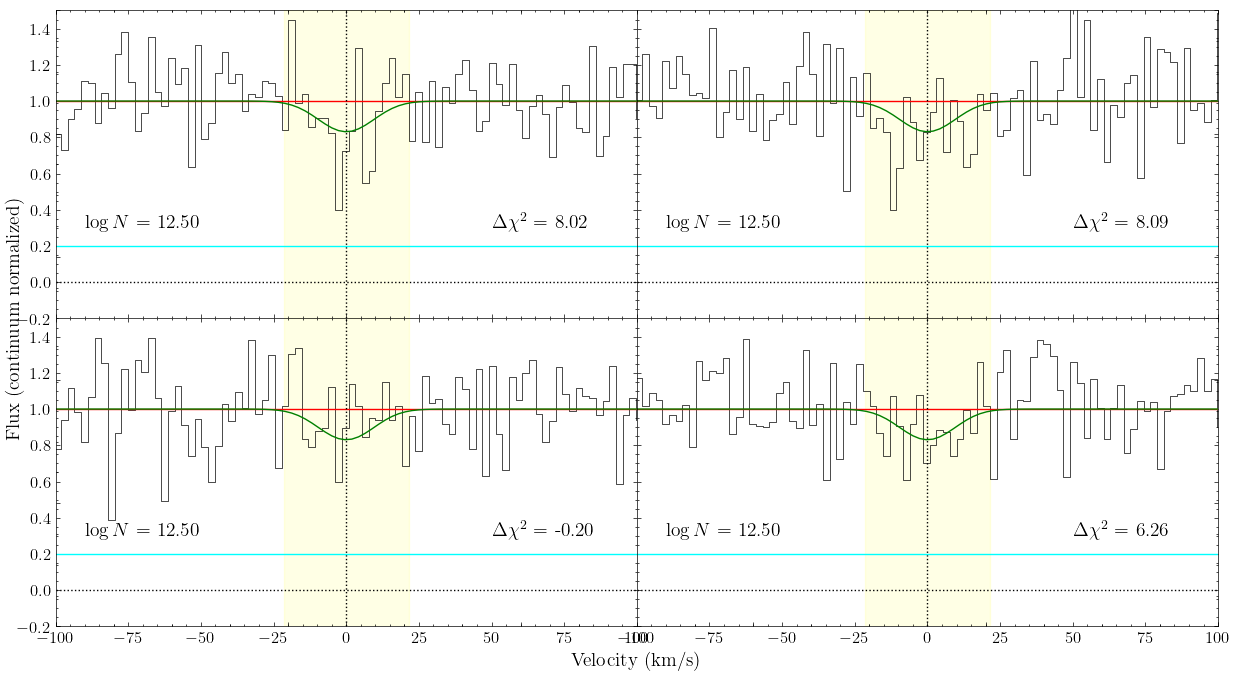

In [24]:
# Pick a trial at random

fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

for i in range(len(logN_plot_grid)):
    
    logN = logN_plot_grid[i]
    ax = axes[i//2, i%2]
    
    # Find the closest logN for which the trial was run
    sample_logN_idx = np.argmin(np.abs(logN_grid-logN))
    sample_trial_idx = np.random.randint(low=0, high=N_trials, size=1)[0]
    
    # Isolate the flux and model
    flux = flux_grid[sample_trial_idx, sample_logN_idx, :]
    model = vp(v, logN)
    
    # Calculate probabilities
    chi_sq = np.sum((flux[idx]-model[idx])**2)/err_std**2
    chi_sq_0 = np.sum((flux[idx]-1)**2)/err_std**2
    delta_chi_sq = chi_sq_0-chi_sq
    S = np.exp(0.5*delta_chi_sq)
    
    # Make the plot
    ax.step(v, flux, where='mid', lw=.5)
    
    ax.axhline(1, color='red')
    ax.axhline(0, color='black', linestyle=':')
    ax.axvline(0, color='black', linestyle=':')

    ax.plot(v, model, color='green')

    ax.step(v, err_std*np.ones(len(v)), where='mid', color='cyan')
    
    ax.axvspan(xmin=-fwhm, xmax=fwhm, color='yellow', alpha=.1)
    
    ax.text(x=-90, y=0.3, s=r'$\log N$ = '+'{:.2f}'.format(logN_plot_grid[i]))
    #ax.text(x=50, y=0.3, s=r'$S$ = ' + '{:.2e}'.format(S))
    ax.text(x=50, y=0.3, s=r'$\Delta \chi^2$ = ' + '{:.2f}'.format(delta_chi_sq))

    ax.set_xlim(-100,100)
    ax.set_ylim(-0.2, 1.5)
    
ax_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_label.set_xlabel('Velocity (km/s)')
ax_label.set_ylabel('Flux (continuum normalized)')
plt.subplots_adjust(wspace=0, hspace=0)

Now start calculating significance

We create a mock absorption spectrum $f_i$ by perturbing Gaussian noise with constant dispersion $\sigma_f$ with a Voigt profile model $\bar{f_i}(\log N)$. We want to develop a formalism to assess the significance of the absorption spectrum. This requires assessing the spectrum under two hypotheses - 

1. The null hypothesis - which states that the given absorption spectrum is purely a consequence of noise, and no source is present (i.e. column density is zero).

2. The alternate hypothesis which states that a source with a particular column density is present.

Let us first deal with the alternate hypothesis by calculating $\chi^2$ over $k$ pixels as -

$$\chi^2 = \sum_{i=1}^k \frac{(f_i - \bar{f_i})^2}{\sigma_f^2}$$

Given how the absorption line $f_i$ is constructed, the residual $f_i - \bar{f_i}$ is just Gaussian noise, so we expect $\chi^2 \sim k$. The corresponding probability of the alternate hypothesis being true, $P_{\mathrm{alt}}$, is given by $P_{\mathrm{alt}} \propto \exp(-0.5 \chi^2)$.

Let us now consider the null hypothesis. Under this scenario, our model flux is given by $\bar{f_i}(\log N \to -\infty) = 1$. Thus, the chi-squared value, $\chi_0^2$ will be given by -

$$\chi_0^2 = \sum_{i=1}^k \frac{(f_i - 1)^2}{\sigma_f^2}$$

For weaker mock absorption lines (small values of $\log N$), the spectrum will in fact be consistent with the noise, so we'd expect $\chi_0^2 \sim k$. However, for stronger absorption lines (large values of $\log N$), the spectrum will not be consistent with the noise, so we'd get $\chi_0^2 \gg k$. The corresponding probability of the null hypothesis being true, $P_{\mathrm{null}}$, is given by $P_{\mathrm{null}} \propto \exp(-0.5 \chi_0^2)$.

We can assess the significance $S$ of the mock absorption line by calculating the ratio of probabilities of the alternative and null hypothesis -

$$S = P_{\mathrm{alt}}/ P_{\mathrm{null}}$$

We will say that a given mock absorption line is significant if $S \gg 1$, and not significant if $S \lesssim 1$. Naturally, mock absorption lines created using a high column density should be significant, and weaker lines should be less significant. We can show this is the case by simplifying the expression for significance $S$ -

$$S = \frac{P_{\mathrm{alt}}}{P_{\mathrm{null}}} = \frac{\exp(-0.5 \chi^2)}{\exp(-0.5 \chi_0^2)} = \exp\left(\frac{1}{2}(\chi_0^2 -\chi^2)\right)$$

For weaker absorption lines, we expect $\chi_0^2 \sim \chi^2 \sim k$, where the calculation takes place over $k$ pixels, so the significance $S \lesssim 1$. On the other hand, for strong absorption lines $\chi_0^2 \gg \chi^2$, so the significance $S \gg 1$. This formalism is therefore well defined. 

Now, we can use the significance to assign upper limits on $\log N$. The significance $S$ looks quite a bit like a normal distribution. More precisely, we can say that a given value $\log N_{m \sigma}$ excludes the null hypothesis by "$m \sigma$" ($m=1,2,3$ etc.) if -

$$S = \exp(0.5 m^2)$$

It is worth defining $\Delta \chi^2$ -

$$\Delta \chi^2 = \chi_0^2 - \chi^2$$

So that the condition for an "$m \sigma$" detection becomes $\Delta \chi^2 = m^2$. Since $\chi_0^2$ increases with the column density $\log N$ while $\chi^2 \sim k$ (where $k$ is the size of the integration window), it follows that a higher detection confidence (larger $m$) will correspond to a larger value of $\log N$. This also makes sense as we need a stronger source to exclude the null hypothesis with a greater confidence.

Finally, the calculation of the significance $S$ for a given $\log N$ may not be precise for just one instantiation of the mock spectrum (given the random nature of noise), so it is ideal to instantiate multiple mock spectra for a fixed $\log N$ by drawing different samples from the noise, and average the significance (or $\Delta \chi^2$) to get the true significance of $\log N$ given a noise pattern.

In [26]:
P_null_grid = np.zeros((N_trials, len(logN_grid)))
P_alt_grid = np.zeros((N_trials, len(logN_grid)))

In [27]:
for i in range(N_trials):
    for j in range(len(logN_grid)):
        P_null_grid[i,j] = np.exp(-0.5*np.sum((flux_grid[i,j,:][idx]-1)**2/err_std**2))
        P_alt_grid[i,j] = np.exp(-0.5*np.sum((flux_grid[i,j,:][idx]-model_grid[j,:][idx])**2/err_std**2))

In [28]:
significance_grid = 2*(np.log(P_alt_grid)-np.log(P_null_grid))
significance_medians = np.array([np.mean(significance_grid[:,i]) for i in range(len(logN_grid))])

In [29]:
sig_med_inv_interp = interpolate.interp1d(x=significance_medians, y=logN_grid, fill_value='extrapolate')

In [30]:
logN_1sig = sig_med_inv_interp(1)
logN_2sig = sig_med_inv_interp(4)
logN_3sig = sig_med_inv_interp(9)

Text(0, 0.5, '$\\Delta \\chi^2$')

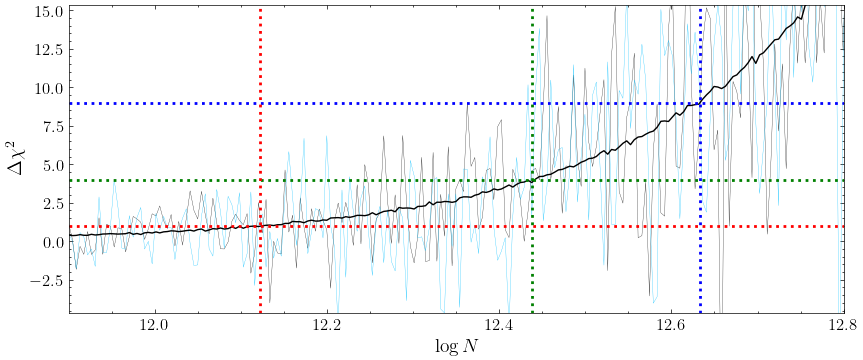

In [31]:
# Plot results from some Monte carlo runs

N_trials_plot = 2
trials_idx = np.random.randint(low=0, high=N_trials, size=N_trials_plot)

fig, ax = plt.subplots(1, figsize=(10,4))

#ax.violinplot([significance_grid[:,j] for j in range(len(logN_grid))], positions=logN_grid, widths=0.2)
for i in range(N_trials_plot):
    ax.plot(logN_grid, significance_grid[trials_idx[i],:], lw=.2)

ax.plot(logN_grid, significance_medians, color='black')

ax.set_xlim(np.min(logN_grid), 12.8)
ax.set_ylim(np.min(significance_medians)-5, np.min(significance_medians)+15)

ax.axhline(1, lw=2, linestyle=':', color='red')
ax.axhline(4, lw=2, linestyle=':', color='green')
ax.axhline(9, lw=2, linestyle=':', color='blue')

ax.axvline(logN_1sig, lw=2, linestyle=':', color='red')
ax.axvline(logN_2sig, lw=2, linestyle=':', color='green')
ax.axvline(logN_3sig, lw=2, linestyle=':', color='blue')

ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$\Delta \chi^2$')

In [32]:
logN_1sig, logN_2sig, logN_3sig

(array(12.12275041), array(12.43787153), array(12.63322455))

In [33]:
logN_2sig-logN_1sig, logN_3sig-logN_2sig

(0.31512111884317306, 0.19535302047955128)

Text(0, 0.5, 'Flux (continuum normalized)')

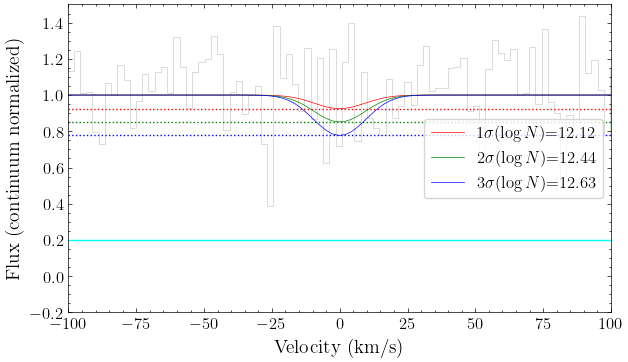

In [34]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.step(v, 1+noise_grid[np.random.randint(low=0, high=N_trials, size=1)[0],
                        np.random.randint(low=0, high=len(logN_grid), size=1)[0],:], 
            where='mid', lw=.5, alpha=.2)
ax.step(v, err_std*np.ones(len(v)), where='mid', color='cyan')

ax.plot(v, vp(v, logN_1sig), lw=.5, label=r'$1 \sigma (\log N)$='+'{:.2f}'.format(logN_1sig), color='red')
ax.plot(v, vp(v, logN_2sig), lw=.5, label=r'$2 \sigma (\log N)$='+'{:.2f}'.format(logN_2sig), color='green')
ax.plot(v, vp(v, logN_3sig), lw=.5, label=r'$3 \sigma (\log N)$='+'{:.2f}'.format(logN_3sig), color='blue')

ax.axhline(np.min(vp(v, logN_1sig)), color='red', linestyle=':')
ax.axhline(np.min(vp(v, logN_2sig)), color='green', linestyle=':')
ax.axhline(np.min(vp(v, logN_3sig)), color='blue', linestyle=':')

ax.legend()
ax.set_xlim(-100,100)
ax.set_ylim(-0.2, 1.5)

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux (continuum normalized)')
#ax.axhline(1, color='black', linestyle=':')
#ax.axhline(0, color='black', linestyle=':')
#ax.axvline(0, color='black', linestyle=':')

In [37]:
1-np.min(vp(v, logN_1sig))

0.07489791611147656

In [35]:
np.min(vp(v, logN_1sig))-np.min(vp(v, logN_2sig)), np.min(vp(v, logN_2sig))-np.min(vp(v, logN_3sig))

(0.07367136428061505, 0.07433883981349076)